# 构建一个简易回测框架

本文的回测框架主要包括：
* 1.从网络等源下载股票数据到本地(或服务器)。
* 2.构建上下文数据类。储存用户信息，包括持有仓位情况，cash等。
* 3.获取历史数据。这一步在本文中转换为从本地数据中提取一定时间区间的股票信息。
* 4.下单函数。构建一个类，让策略在买卖点处对股票进行下单并对应计算仓位，储存收益信息等等。
* 5.回测。使用策略对股票进行回测。

# 1.下载股票数据
本文这里使用baostock包，下载近5年的股票日线数据到本地。由于本地储存能力有限，只选择部分股票的近5年数据，即2018.01.01到2023.01.01的数据。

⭐在编写本文时同时也尝试了其他平台/方式下载股票数据，但是失效的居多，或参数被重新调整，或下载的数据需要重新清洗。baostock包于2023年5月仍然能下载且数据较为干净。

📕 baostock数据的获取 http://baostock.com/baostock/index.php/A%E8%82%A1K%E7%BA%BF%E6%95%B0%E6%8D%AE

In [1]:
import baostock as bs
import pandas as pd

In [2]:
class Get_data_from_baostock:
    
    def __init__(self, stock, start_date, end_date, freq, adjustflag):
        self.stock = stock
        self.start_date = start_date
        self.end_date = end_date
        self.freq = freq
        self.adjustflag = adjustflag
    
    def download_data_from_baostock(self):
        lg = bs.login()
        if str(self.stock)[0] == '6':
            stock_name = 'sh.' + str(self.stock)
        else:
            stock_name = 'sz.' + str(self.stock)
        
        if self.freq in ['d', 'w', 'm']:
            fields = "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST"
        else:
            fields = "date,time,code,open,high,low,close,volume,amount,adjustflag"
        
        rs = bs.query_history_k_data_plus(stock_name,
                                      fields,
                                      start_date = self.start_date, 
                                      end_date = self.end_date,
                                      frequency = str(self.freq), 
                                      adjustflag = str(self.adjustflag) # 2是前复权
                                     )
        bs.logout()
        
        df = pd.DataFrame(rs.data)
        df.columns = fields.split(',')
         
        df['open'] = [float(t) for t in df['open']]
        df['close'] = [float(t) for t in df['close']]
        df['high'] = [float(t) for t in df['high']]
        df['low'] = [float(t) for t in df['low']]  
        df['amount'] = [float(t) for t in df['amount']]
        df['volume'] = [float(t) for t in df['volume']]
        
        
        if self.freq in ['5','15','30','60']:
            df['time'] = [t[:-3] for t in df['time']] # 把毫秒去掉，否则int太长了无法转化为datatime格式
            df['time'] = pd.to_datetime(df['time'])
            df = df.loc[:, ['time','open','high','low','close','amount','volume']]
            df.rename(columns = {'time':'datetime'},inplace = True)
            df.set_index('datetime', drop=True, inplace = True) # 用时间作为index
        elif self.freq in ['d', 'w', 'm']:
            # df = df.loc[:, ['date','open','high','low','close','amount','volume']]
            df['date'] = pd.to_datetime(df['date'])
            df.rename(columns = {'date':'datetime'},inplace = True)
            df.set_index('datetime', drop=True, inplace = True) # 用时间作为index
        else:
            print('k线时间输入错误')
        
        self.df = df
    
    def save_baostock_data_to_local(self,address):
        self.df.to_csv(address + '%s_%s.csv' % (self.stock,self.freq))
        print('文件已保存到'+ address + '%s_%s.csv' % (self.stock,self.freq))

In [3]:
GD = Get_data_from_baostock('603019','2015-01-01','2023-01-01','d','2')
data = GD.download_data_from_baostock()
address = 'E:/data/stock_data/'
GD.save_baostock_data_to_local(address)

login success!
logout success!
文件已保存到E:/data/stock_data/603019_d.csv


In [4]:
GD2 = Get_data_from_baostock('600036','2018-01-01','2023-01-01','d','2')
data2 = GD2.download_data_from_baostock()
address = 'E:/data/stock_data/'
GD2.save_baostock_data_to_local(address)

login success!
logout success!
文件已保存到E:/data/stock_data/600036_d.csv


# 2.构建上下文数据类
创建一个context类，用于储存用户的cash，开始时间，结束时间等等信息。

* attribute_history函数:用户传入股票security，往回的count天，可以得到该股票距离今天count天的历史数据。

* attribute_daterange_history函数:用户传入股票security，一个时间区间[start_date, end_date]，得到这股票在这时间区间的历史数据。

以上获取的数据都是在开盘日的数据。

In [5]:
class Context:
    
    def __init__(self, cash, start_date, end_date):
        self.cash = cash
        self.start_date = start_date
        self.end_date = end_date
        self.positions = {'603019':0}  # 持仓信息，存在字典里
        self.benchmark = None # 基准股票
        self.dt = None

In [6]:
class G:
    pass

g = G()
# 建立一个全局对象，可以随时创建属性

In [7]:
def set_benchmark(security): # 只支持一只股票作为基准股票
    context.benchmark = security

In [8]:
CASH = 100000
START_DATE = '2018-01-01'
END_DATE = '2022-01-01'
context = Context(CASH, START_DATE, END_DATE)

# 3.获取历史数据
* attribute_history函数：获取距离今天前count天的历史数据
* attribute_daterange_history函数：获取一段时间区间内的历史数据

In [9]:
import dateutil
import datetime

def attribute_history(security, count, fields =('open', 'close', 'high', 'low', 'volume')):
    try:
        data = pd.read_csv( 'E:/data/stock_data/' + security + '_d.csv')
        today = datetime.datetime.now().strftime("%Y-%m-%d")
        end_date = pd.to_datetime(today) - datetime.timedelta(days = 1)
        start_date = pd.to_datetime(today) - datetime.timedelta(days = count)
        return attribute_daterange_history(security, start_date, end_date, fields)
    except FileNotFoundError:
        return print('无%s的股票数据，请去下载。' %security)

def attribute_daterange_history(security, start_date, end_date, fields=('open', 'close', 'high', 'low', 'volume')):
    try:
        data = pd.read_csv( 'E:/data/stock_data/' + security + '_d.csv')
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        data['datetime'] = pd.to_datetime(data['datetime'])
        data1 = data.loc[data['datetime'] >= start_date]
        data2 = data1.loc[data1['datetime'] <= end_date]
        data2.set_index('datetime', drop=True, inplace = True)
        return data2[list(fields)]        
    except FileNotFoundError:
        return print('无%s的股票数据，请去下载。' %security)

In [10]:
# data = attribute_daterange_history('603019','20180101','20230101')
data = attribute_daterange_history('603019',START_DATE,END_DATE)
data.head()

,open,close,high,low,volume
datetime,,,,,
2018-01-02,20.445622,20.460645,20.685983,19.934857,16014428.0
2018-01-03,20.525742,21.336958,21.351980,20.285383,26750010.0
2018-01-04,21.291890,21.321935,21.547272,21.106613,21343614.0
2018-01-05,21.532250,21.326943,22.463645,21.291890,26255059.0
2018-01-08,21.031500,20.711020,21.126642,20.375518,18983745.0


# 4.下单函数

In [11]:
# CASH = 10000
# START_DATE = '2018-01-01'
# END_DATE = '2023-01-01'

In [12]:
def get_today_data(security):
    # today = context.dt.strftime('%Y-%m-%d')
    today = pd.to_datetime(context.dt)
    price = data.loc[today,:]
    return price

In [13]:
def _order(today_data, security, amount):
    p = today_data['open']
    
    if context.cash - amount * p < 0:
        amount = int(context.cash/p)
        print('现金不足，已调整为%d' %amount)
    
    if amount %100 != 0:
        if amount != -context.positions.get(security,0):
            amount = int(amount/100) * 100
            print('不是100的倍数，已调整为%d' %amount)
    
    if context.positions.get(security,0) <-amount:
        amount = -context.positions.get(security,0)
        print('卖出股票不能超过持仓数，已调整为%d' %amount)
    
    context.positions[security] = context.positions.get(security,0) + amount
    context.cash -= amount * p
    
    if context.positions[security] == 0:
        del context.positions[security]

In [14]:
# _order(get_today_data('601319'),'601319',100)
# print(context.positions)

In [15]:
# _order(get_today_data('601319'),'601319',-200)
# print(context.positions)

用_order函数作为底层函数，封装下面4个函数：
* order函数：输入股票和买的数量即可。
* order_target函数：输入股票和目标买到的股票数量。如目前持仓100，想达到持仓300。
* order_value函数：输入股票和买多少钱的股票。如想购入1000块钱的该股票。
* order_target_value函数：这里的target_value指的是买到多少股值。如目前股值3块，目标买到5块。

In [16]:
def order(security, amount):
    today_data = get_today_data(security)
    _order(today_data, security, amount)

def order_target(security, amount):
    if amount<0:
        print('数量不能为负，已调整为0')
        amount = 0
    
    today_data = get_today_data(security)
    hold_amount = context.positions.get(security,0)
    delta_amount = amount - hold_amount
    _order(today_data, security, delta_amount)

def order_value(security, value):
    today_data = get_today_data(security)
    amount = int(value/today_data['open'])
    _order(today_data, security, amount)
    
def order_target_value(security, value):
    today_data = get_today_data(security)
    if value<0:
        print('价值不能为负，已调整为0')
        value = 0
    
    hold_value = context.positions.get(security,0)* today_data['open']
    delta_value = value - hold_value
    order_value(security, delta_value)

In [18]:
#order('603019',100)
#context.positions

In [19]:
# order_target('601319',200)
# order_target_value('601319',1000)
# context.positions

# 5.回测

In [27]:
from matplotlib import pyplot as plt

def run():
    init_value = context.cash
    initialize(context)
    date_range = attribute_daterange_history(g.security,context.start_date, context.end_date).index 
    plt_df = pd.DataFrame(index=date_range,columns=['value'])
    for dt in date_range:
        context.dt = dt
        handle_data(context)
        value = context.cash
        for stock in context.positions:
            today_data = get_today_data(stock)
            p = today_data['open']
            value += p * context.positions[stock]
        plt_df.loc[dt, 'value'] = value
    plt_df['ratio'] = (plt_df['value'] - init_value)/init_value
    
    bm_df = attribute_daterange_history(context.benchmark, context.start_date, context.end_date)
    bm_init = bm_df['open'][0]
    plt_df['benchmark_ratio'] = (bm_df['open'] - bm_init)/bm_init
    
    plt_df[['ratio', 'benchmark_ratio']].plot()
    # plt_df['ratio'].plot()
    # plt_df['benchmark_ratio'].plot()
    plt.show()


⭐模拟平台中用户调用函数和类来编写策略和回测。这里使用的是双均线策略:金叉全部买入，死叉全部卖出，对603019股票在2020-01-01到2021-01-01期间进行收益率回测，初始现金为100000。

In [28]:
def initialize(context):
    set_benchmark('603019')
    g.p1 = 5
    g.p2 = 30
    g.security = '603019'
    
def handle_data(context):
    hist = attribute_history(g.security, g.p2)
    ma5 = hist['close'][-g.p1:].mean()
    ma30 = hist['close'].mean()
    
    if ma5 > ma30 and g.security not in context.positions:
        order_value(g.security, context.cash)
    elif ma5 < ma30  and g.security in context.positions:
        order_target(g.security,0)

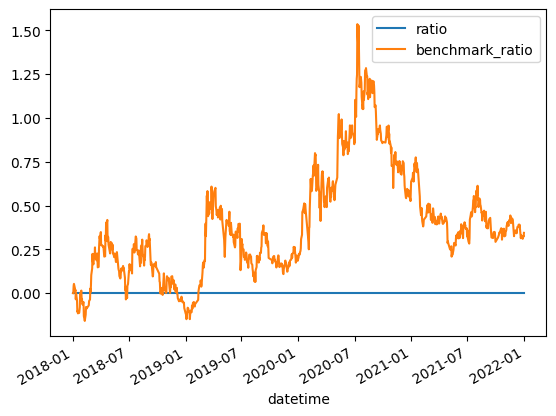

In [29]:
run()